In [1]:
pip install pyspark

In [2]:
#@title Default title text
## Healthcare and medical service providers
## Download Input dataset for analytics
##https://propensity-labs-screening.s3.amazonaws.com/analytics/analytics_input.csv

In [3]:
from pyspark.sql import SparkSession
from google.colab import files

In [4]:
#Create Spark Session
spark = SparkSession.builder.appName("SparkSessionpropensity") \
    .getOrCreate()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#Read CSV to Dataframe
df=spark.read.csv('/content/drive/MyDrive/Datasets/analytics_input.csv',header=True)
df.show()



+--------------------+-----------+--------------------+-----------------------+-------------+--------------+-----------------+------------------------------------+------------------+-------------------------+------------------------+-------------------------+
|      DRG Definition|Provider Id|       Provider Name|Provider Street Address|Provider City|Provider State|Provider Zip Code|Hospital Referral Region Description| Total Discharges | Average Covered Charges | Average Total Payments |Average Medicare Payments|
+--------------------+-----------+--------------------+-----------------------+-------------+--------------+-----------------+------------------------------------+------------------+-------------------------+------------------------+-------------------------+
|039 - EXTRACRANIA...|      10001|SOUTHEAST ALABAMA...|   1108 ROSS CLARK C...|       DOTHAN|            AL|            36301|                         AL - Dothan|                91|                $32963.07|            

In [7]:
#Display Scheme
df.printSchema()

root
 |-- DRG Definition: string (nullable = true)
 |-- Provider Id: string (nullable = true)
 |-- Provider Name: string (nullable = true)
 |-- Provider Street Address: string (nullable = true)
 |-- Provider City: string (nullable = true)
 |-- Provider State: string (nullable = true)
 |-- Provider Zip Code: string (nullable = true)
 |-- Hospital Referral Region Description: string (nullable = true)
 |--  Total Discharges : string (nullable = true)
 |--  Average Covered Charges : string (nullable = true)
 |--  Average Total Payments : string (nullable = true)
 |-- Average Medicare Payments: string (nullable = true)



In [8]:
#Change Column names to remove spaces, lower case and replace spaces in column names with "_" (underscore)
for old_column in df.columns:
    new_column = old_column.replace(" ", "_").lower()
    df = df.withColumnRenamed(old_column, new_column)

In [9]:
df.columns

['drg_definition',
 'provider_id',
 'provider_name',
 'provider_street_address',
 'provider_city',
 'provider_state',
 'provider_zip_code',
 'hospital_referral_region_description',
 '_total_discharges_',
 '_average_covered_charges_',
 '_average_total_payments_',
 'average_medicare_payments']

In [10]:
#Identify all rows with Null values for provider id
df.filter(df.provider_id.isNull()).show()

+--------------+-----------+-------------+-----------------------+-------------+--------------+-----------------+------------------------------------+------------------+-------------------------+------------------------+-------------------------+
|drg_definition|provider_id|provider_name|provider_street_address|provider_city|provider_state|provider_zip_code|hospital_referral_region_description|_total_discharges_|_average_covered_charges_|_average_total_payments_|average_medicare_payments|
+--------------+-----------+-------------+-----------------------+-------------+--------------+-----------------+------------------------------------+------------------+-------------------------+------------------------+-------------------------+
+--------------+-----------+-------------+-----------------------+-------------+--------------+-----------------+------------------------------------+------------------+-------------------------+------------------------+-------------------------+



In [11]:
from pyspark.sql.functions import col, regexp_replace
from pyspark.sql.functions import col, sum, avg

In [12]:
payment_columns = ['_total_discharges_','_average_covered_charges_', '_average_total_payments_', 'average_medicare_payments']
for col_name in payment_columns:
    df = df.withColumn(col_name, regexp_replace(col(col_name), "\\$", "").cast("float"))


In [13]:
#Change fields with Payment information into numbers by using Lambda functions in python
convert_to_number = lambda col_name: col(col_name).cast('double')

# Apply the lambda function to the specified columns
for col_name in payment_columns:
    df = df.withColumn(col_name, convert_to_number(col_name))

df.printSchema()

root
 |-- drg_definition: string (nullable = true)
 |-- provider_id: string (nullable = true)
 |-- provider_name: string (nullable = true)
 |-- provider_street_address: string (nullable = true)
 |-- provider_city: string (nullable = true)
 |-- provider_state: string (nullable = true)
 |-- provider_zip_code: string (nullable = true)
 |-- hospital_referral_region_description: string (nullable = true)
 |-- _total_discharges_: double (nullable = true)
 |-- _average_covered_charges_: double (nullable = true)
 |-- _average_total_payments_: double (nullable = true)
 |-- average_medicare_payments: double (nullable = true)



In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

<Figure size 1200x600 with 0 Axes>

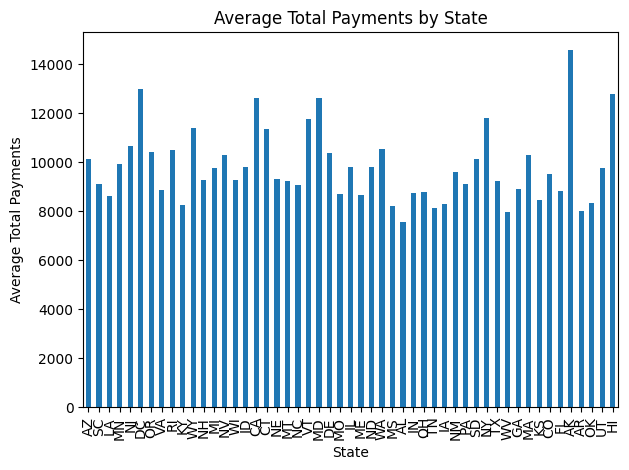

In [15]:
#Plot a Bar chart by state and "Average Total Payments" and zip code vs "total_charges"
state_payments = df.groupBy("provider_state").agg(avg("_average_total_payments_").alias("Average Total Payments"))

# Convert the grouped data to a Pandas DataFrame for plotting
state_payments_pd = state_payments.toPandas()

# Plot bar chart for "Average Total Payments" by state
plt.figure(figsize=(12, 6))
state_payments_pd.plot(kind="bar", x="provider_state", y="Average Total Payments", legend=None)
plt.xlabel("State")
plt.ylabel("Average Total Payments")
plt.title("Average Total Payments by State")
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

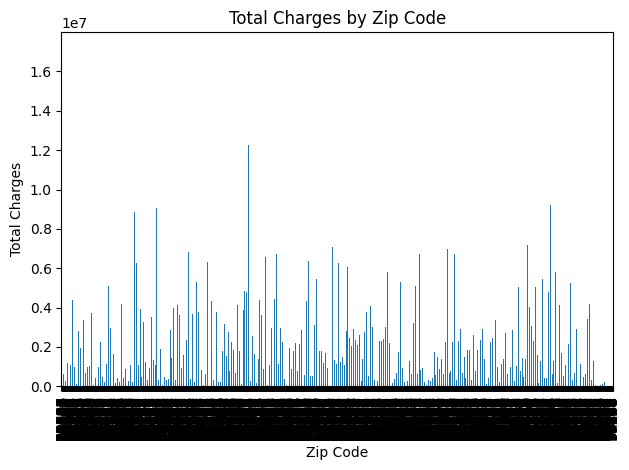

In [16]:
# zip code vs "total_charges"

zip_total_charges = df.groupBy("provider_zip_code").agg(sum("_average_covered_charges_").alias("total_charges"))

# Convert the grouped data to a Pandas DataFrame for plotting
zip_total_charges_pd = zip_total_charges.toPandas()

# Plot bar chart for "total_charges" by zip code
plt.figure(figsize=(12, 6))
zip_total_charges_pd.plot(kind="bar", x="provider_zip_code", y="total_charges", legend=None)
plt.xlabel("Zip Code")
plt.ylabel("Total Charges")
plt.title("Total Charges by Zip Code")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [17]:
#BONUS - Plot intersting statistics from the dataset


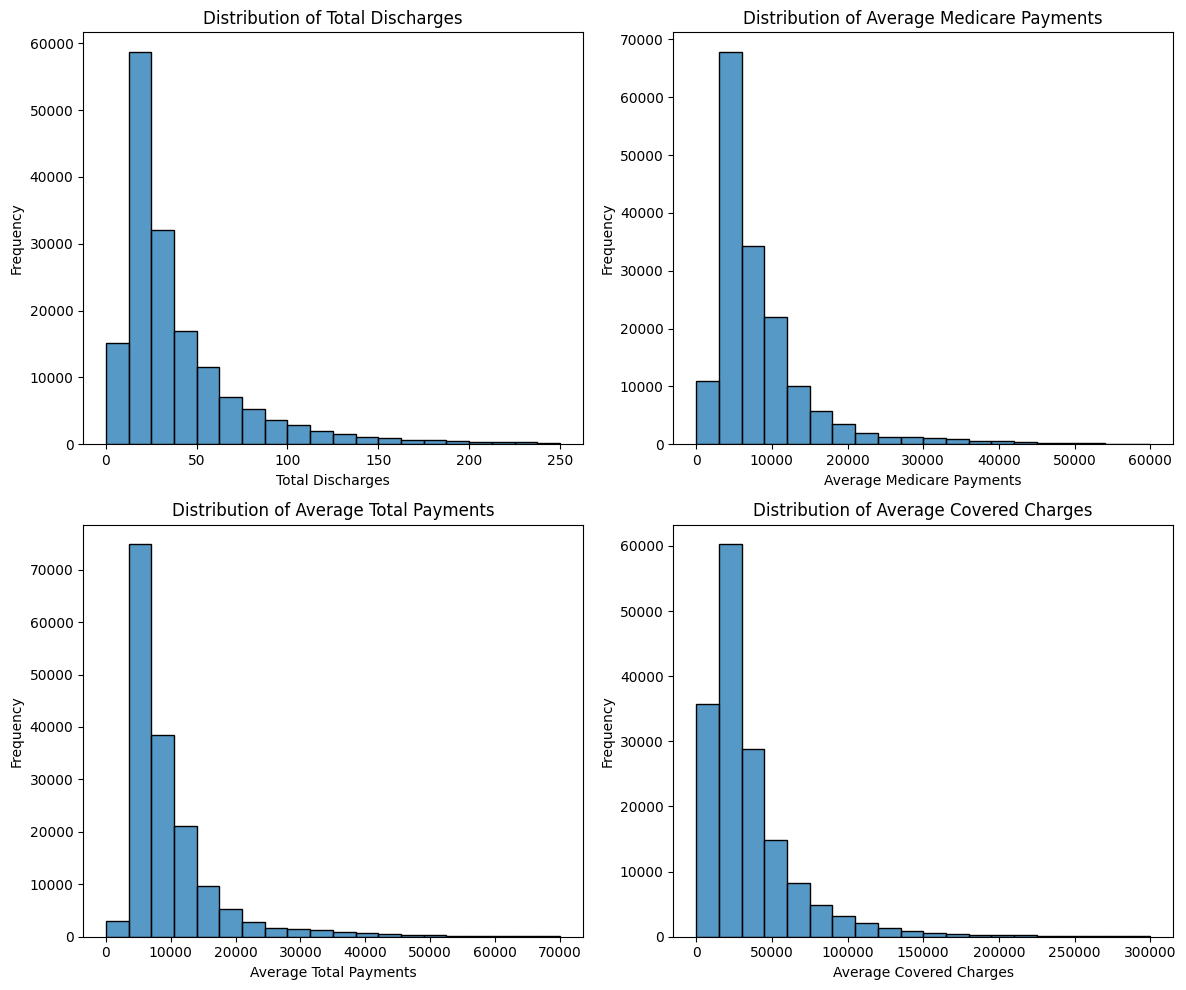

In [23]:
# Create subplots for the histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

data_num=df.select(payment_columns).toPandas()

# Plot Histograms using Seaborn
sns.histplot(data=data_num, x="_total_discharges_", bins=20, binrange=(0, 250), edgecolor="black", ax=axes[0, 0])
sns.histplot(data=data_num, x="average_medicare_payments", bins=20,binrange=(0, 60000), edgecolor="black", ax=axes[0, 1])
sns.histplot(data=data_num, x="_average_total_payments_", bins=20, binrange=(0, 70000),edgecolor="black", ax=axes[1, 0])
sns.histplot(data=data_num, x="_average_covered_charges_", bins=20,binrange=(0, 300000), edgecolor="black", ax=axes[1, 1])

# Set titles and labels
axes[0, 0].set_title("Distribution of Total Discharges")
axes[0, 0].set_xlabel("Total Discharges")
axes[0, 0].set_ylabel("Frequency")

axes[0, 1].set_title("Distribution of Average Medicare Payments")
axes[0, 1].set_xlabel("Average Medicare Payments")
axes[0, 1].set_ylabel("Frequency")

axes[1, 0].set_title("Distribution of Average Total Payments")
axes[1, 0].set_xlabel("Average Total Payments")
axes[1, 0].set_ylabel("Frequency")

axes[1, 1].set_title("Distribution of Average Covered Charges")
axes[1, 1].set_xlabel("Average Covered Charges")
axes[1, 1].set_ylabel("Frequency")

# Adjust layout and show plots
plt.tight_layout()
plt.show()

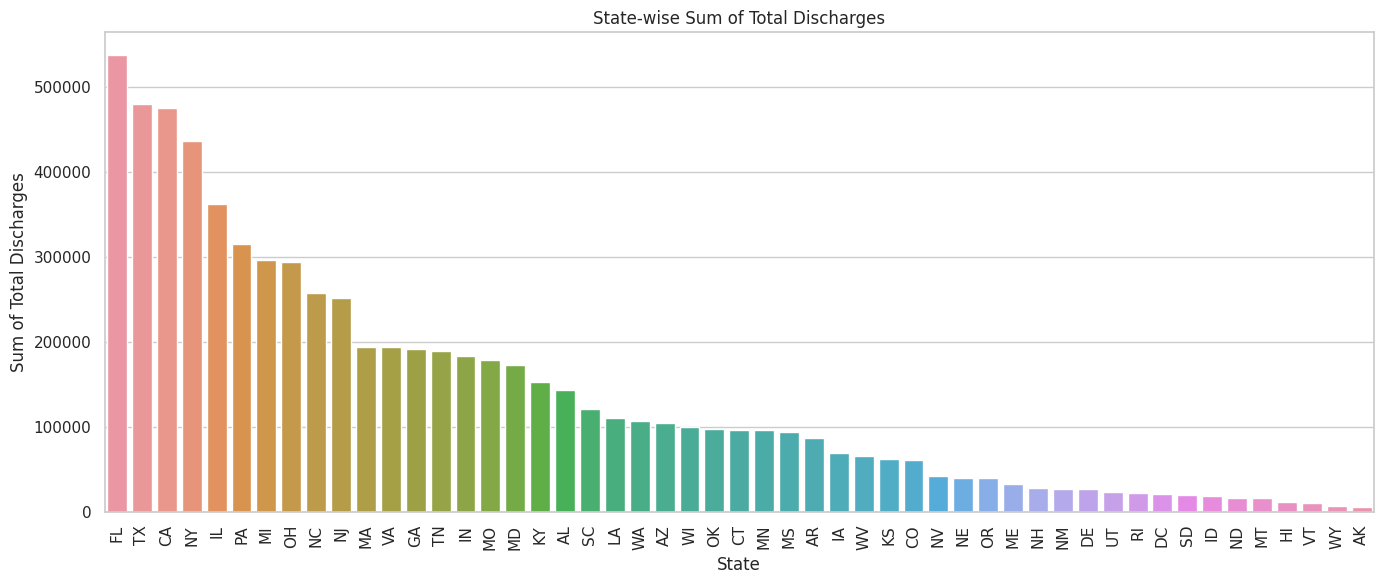

In [24]:
data_discharges = df.groupBy("provider_state").sum("_total_discharges_").toPandas().sort_values(by="sum(_total_discharges_)", ascending=False)

# Set the style for Seaborn plots
sns.set(style="whitegrid")

# Plot - Bar Plot: State-wise Sum of Total Discharges
plt.figure(figsize=(14, 6))
sns.barplot(data=data_discharges, x="provider_state", y="sum(_total_discharges_)")
plt.xlabel("State")
plt.ylabel("Sum of Total Discharges")
plt.title("State-wise Sum of Total Discharges")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

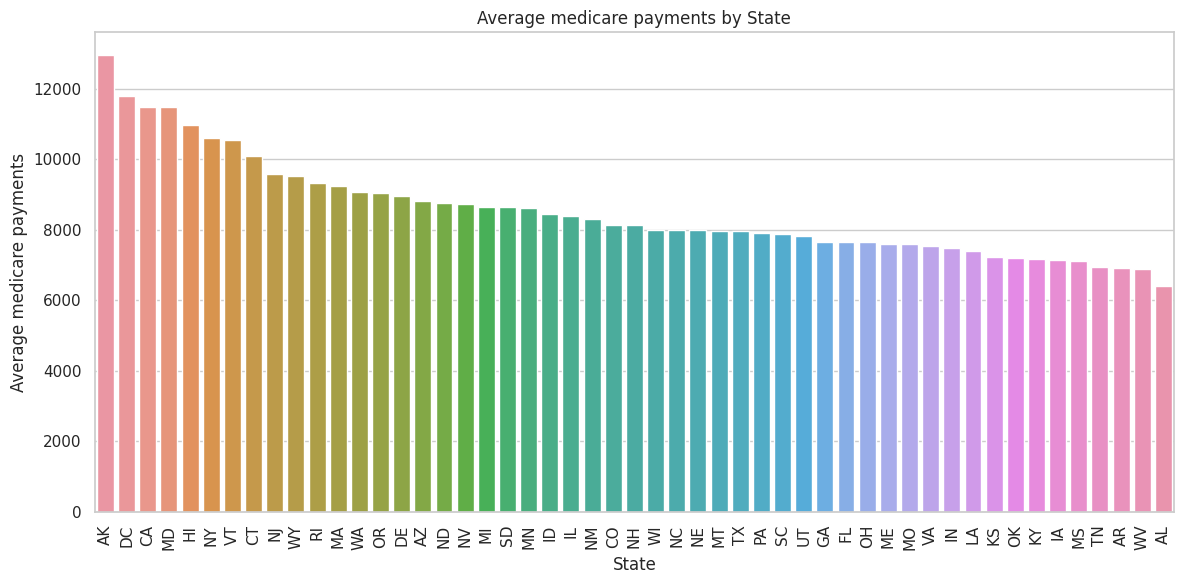

In [25]:
state_payments = df.groupBy("provider_state").avg("average_medicare_payments")\
                   .toPandas().sort_values(by="avg(average_medicare_payments)", ascending=False)

# Plot Bar Chart - Average medicare payments by State
plt.figure(figsize=(12, 6))
sns.barplot(data=state_payments, x="provider_state", y="avg(average_medicare_payments)")
plt.xlabel("State")
plt.ylabel("Average medicare payments")
plt.title("Average medicare payments by State")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

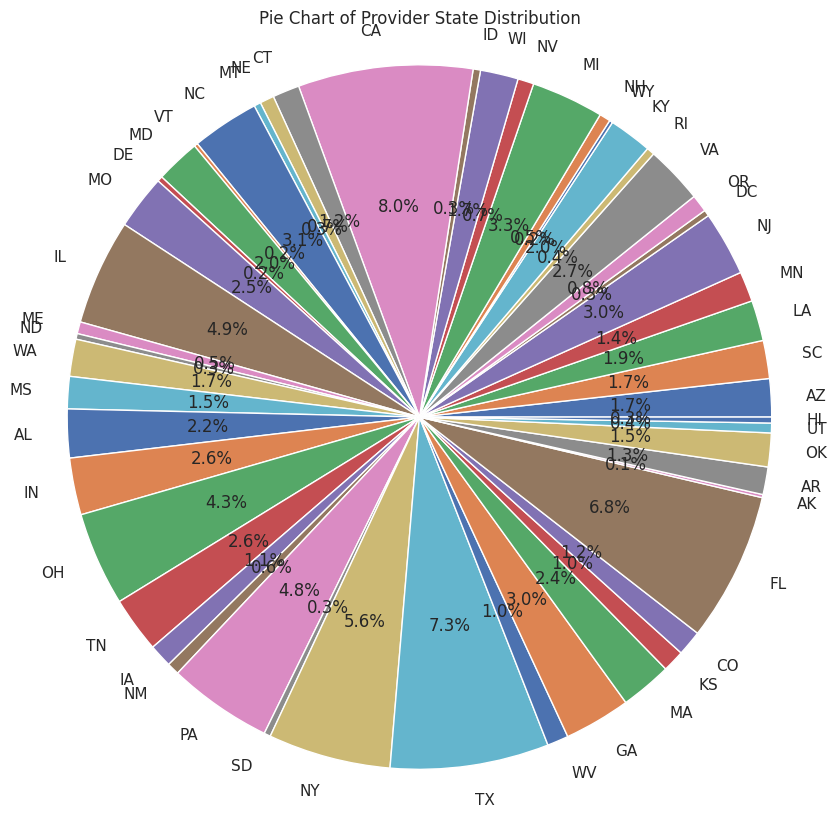

In [26]:
# Group by Provider State description and count occurrences
region_counts = df.groupBy("Provider_State").count().toPandas()

# Plot Pie Chart ofProvider State Distribution using Seaborn
plt.figure(figsize=(10, 10))
plt.pie(region_counts["count"], labels=region_counts["Provider_State"], autopct="%.1f%%")
plt.title("Pie Chart of Provider State Distribution")
plt.axis("equal")
plt.show()

<ipython-input-27-0e72af83e838>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.toPandas().corr(), annot=True, cmap="coolwarm")


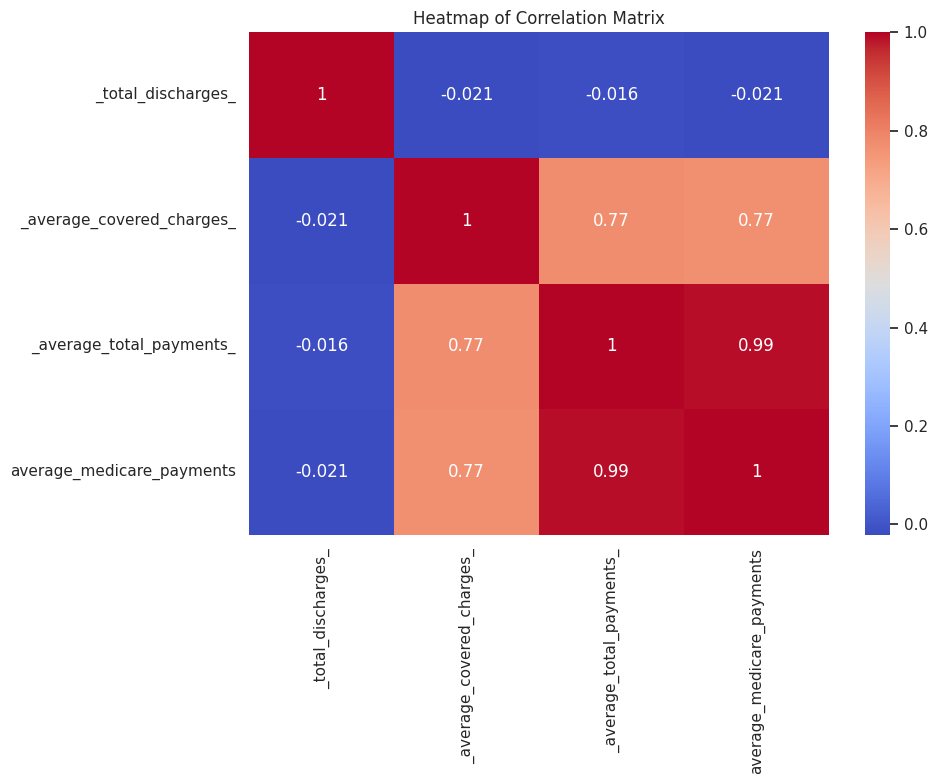

In [27]:
# Plot Heatmap of Correlation Matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(df.toPandas().corr(), annot=True, cmap="coolwarm")
plt.title("Heatmap of Correlation Matrix")
plt.tight_layout()
plt.show()

In [29]:
#Write the Dataset to a Parquet format partitioned by State

output_path = "output_parquet_state"
df.write.partitionBy("Provider_State").parquet(output_path)

In [30]:
columns = df.columns

# Calculate the count of unique values for each column
unique_value_counts = [(column, df.select(column).distinct().count()) for column in columns]

# Print the results
for column, count in unique_value_counts:
    print(f"{column}: {count} unique values")


drg_definition: 100 unique values
provider_id: 3339 unique values
provider_name: 3203 unique values
provider_street_address: 3326 unique values
provider_city: 1977 unique values
provider_state: 51 unique values
provider_zip_code: 3053 unique values
hospital_referral_region_description: 306 unique values
_total_discharges_: 642 unique values
_average_covered_charges_: 160236 unique values
_average_total_payments_: 147842 unique values
average_medicare_payments: 150328 unique values
